In [121]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import timeit
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import ops
import keras_cv

In [122]:
import os 
import torch
from pprint import pprint
 
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

import matplotlib.pyplot as plt

In [123]:
model = torch.load("/Users/mgx/Downloads/checkpoint.pth", map_location=torch.device('cpu'))

torch.Size([3, 4000, 3000])
{'boxes': tensor([[1854.2380, 3435.1433, 2284.8357, 3666.2400],
        [1967.4281, 3051.4839, 2088.9023, 3127.1685],
        [2028.7134, 3432.1106, 2274.9941, 3604.4304],
        [1329.7472, 2310.4663, 1372.3457, 2389.2087]]), 'labels': tensor([1, 1, 1, 1]), 'scores': tensor([0.9899, 0.9699, 0.8776, 0.8550])}
torch.Size([3, 4000, 3000])


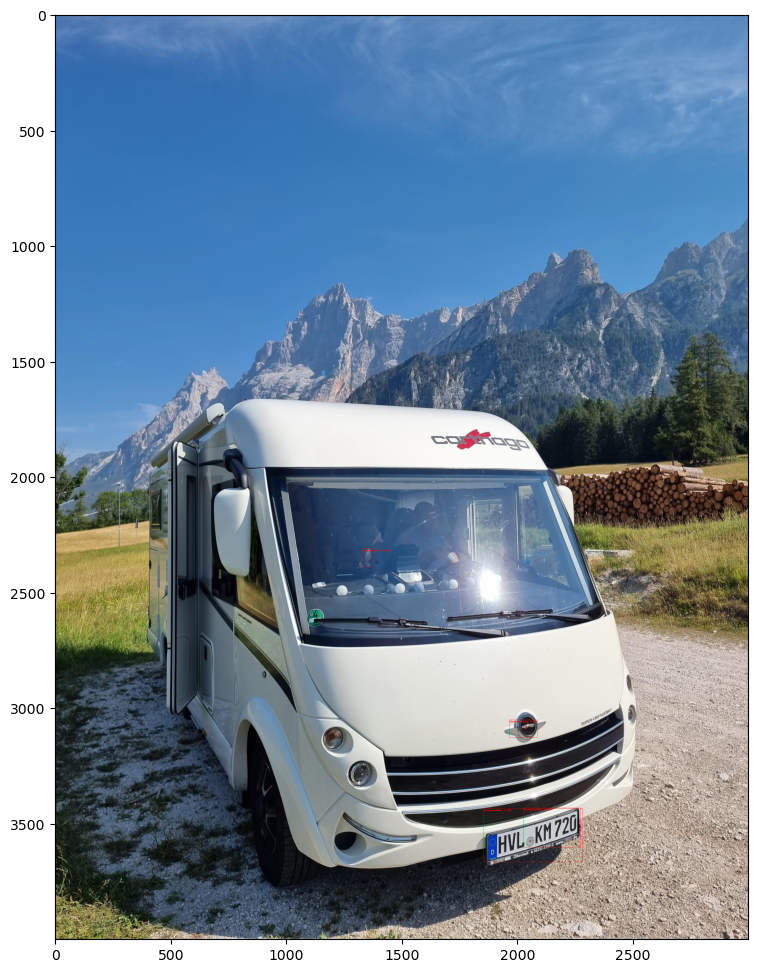

In [124]:
img_path = "/Users/mgx/Library/CloudStorage/GoogleDrive-skatorlp@googlemail.com/Meine Ablage/Licence Plate Detection Dataset v1/train/20220720_101351.jpeg"

image = read_image(img_path) / 255.0
print(image.shape)
device = torch.device('cpu')
model.eval()
with torch.no_grad():
    #x = eval_transform(image)
    x = image
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]
    print(pred)

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
print(image.shape)
pred_labels = [f"license plate: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

box = pred_boxes[0].tolist()

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [125]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def inference_resizing(image, pad=True):
    # Compute Preprocess Shape
    image = ops.cast(image, dtype="float32")
    old_h, old_w = image.shape[0], image.shape[1]
    scale = 1024 * 1.0 / max(old_h, old_w)
    new_h = old_h * scale
    new_w = old_w * scale
    preprocess_shape = int(new_h + 0.5), int(new_w + 0.5)

    # Resize the image
    image = ops.image.resize(image[None, ...], preprocess_shape)[0]

    # Pad the shorter side
    if pad:
        pixel_mean = ops.array([123.675, 116.28, 103.53])
        pixel_std = ops.array([58.395, 57.12, 57.375])
        image = (image - pixel_mean) / pixel_std
        h, w = image.shape[0], image.shape[1]
        pad_h = 1024 - h
        pad_w = 1024 - w
        image = ops.pad(image, [(0, pad_h), (0, pad_w), (0, 0)])
        # KerasCV now rescales the images and normalizes them.
        # Just unnormalize such that when KerasCV normalizes them
        # again, the padded values map to 0.
        image = image * pixel_std + pixel_mean
    return image

In [126]:
#model = keras_cv.models.SegmentAnythingModel.from_preset("sam_huge_sa1b")
model = keras_cv.models.SegmentAnythingModel.from_preset("sam_base_sa1b")
image = np.array(keras.utils.load_img(img_path))
original_resolution = image.shape[:2]
image = inference_resizing(image)

In [127]:
def scale_bbox(input_res, output_res, bbox):
    # input_res and output_res are tuples of (width, height)
    # bbox is a list of [x1, y1, x2, y2] coordinates
    # returns a scaled bbox as a list of [x1, y1, x2, y2] coordinates
    max_scale = min(output_res[0] / input_res[0], output_res[1] / input_res[1]) # scaling factor for the longest side
    scaled_bbox = []
    for i in range(4):
        scaled_bbox.append(int(round(bbox[i] * max_scale)))
    return scaled_bbox

scaled_box = scale_bbox(original_resolution, (1024, 1024), box)
print(original_resolution, box, scaled_box) 

(4000, 3000) [1854, 3435, 2284, 3666] [475, 879, 585, 938]


2024-02-01 00:03:54.922528: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: segment_anything_model_1/sam_prompt_encoder_1/cond/branch_executed/_7


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


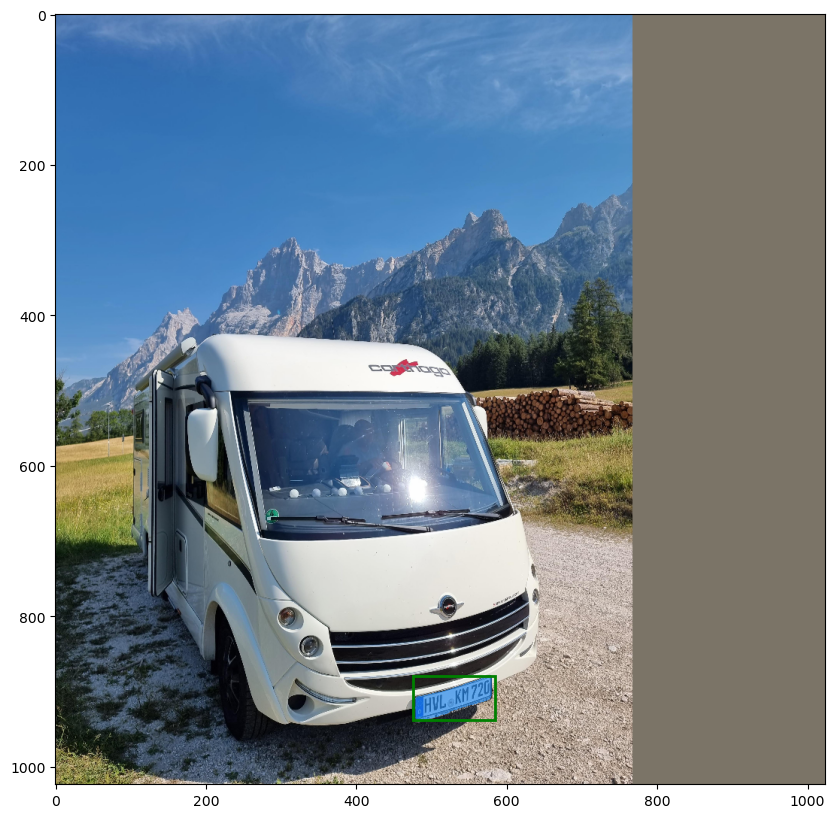

In [128]:
# Let's specify the box
box = scaled_box
input_box = np.array([[box[0], box[1]], [box[2], box[3]]])

outputs = model.predict(
    {"images": image[np.newaxis, ...], "boxes": input_box[np.newaxis, np.newaxis, ...]}
)
mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
mask = ops.convert_to_numpy(mask) > 0.0

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
#plt.axis("off")
plt.show()